# Stepping away from linear interpolation

In [1]:
__author__ = 'Nick Dingwall'

**TL;DR** Interpolated average precision is a common metric for classification tasks. However, interpolating linearly between operating points, as in [scikit-learn's implementation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score), systematically rewards models that assign few discrete scores when there are more negative than positive examples. We propose a __step-wise interpolation__ strategy that addresses this problem and reflects the literature, and we include code to compute average precision scores using this interpolation.

0. [Precision and recall](#Precision-and-recall)
0. [Average precision](#Average-precision)
0. [Interpolated average precision](#Interpolated-average-precision)
0. [Proposal: step-wise interpolation](#Proposal:-step-based-interpolation)
0. [The intuition behind step-wise interpolation](#The-intuition-behind-step-function-interpolation)
0. [Scikit-learn](#Scikit-learn)
0. [Hammering home the point](#Hammering-home-the-point)
0. [Code](#Code)

In [2]:
from average_precision_post_code import *

## Precision and recall

Consider a classifier whose job is to distinguish between photographs of apples and photographs of oranges. We'll encode an orange as a positive example and an apple as a negative example. The classifier assigns scores between 0 and 1 like this:

<img src="fig/pr_example_tight.png" />

We've added a dotted blue line at 0.38, which we'll call the threshold for _oranginess_: anything with a score more than 0.38 is labelled as an orange, and anything with a score less than 0.38 is labelled an apple. We can interpret this as splitting the available data into two bins, <em>B&plus;</em> and <em>B&minus;</em>. Unfortunately this isn't a very good classifier: we've found 4 out of the 5 oranges, but we've also labelled 2 out of the 5 apples as oranges. These two measures are called **recall** and **precision**, and ideally we want both to be high.

+ **Precision**: the fraction of objects in <em>B&plus;</em> that are in fact positive.
+ **Recall**: the fraction of true positives correctly assigned to <em>B&plus;</em>.

By selecting different thresholds, we can weigh up precision and recall: a higher threshold is likely to give us higher precision, and a lower threshold will give us a higher recall.

Since there are only 10 examples here, there are only 11 interesting places we can put the threshold: between some pair of them, or above or below all of the scores. Here's a table showing all of the precision and recall scores we could get by moving the threshold.

<img src="fig/table.png" />

It's worth paying attention to the top row's precision: we've defined 0/0 = 1 which seems ridiculous until you consider that, out of the 0 examples we labelled as positives, all 0 were in fact positive &mdash; we didn't make a single mistake! If this seems unprincipled, accept it as a definition for now: we'll come back to it.

If we have a spread of scores, then as we increase the threshold from 0 to 1, we will incrementally improve the recall by moving positive examples from the negative bin <em>B&minus;</em> to the positive bin <em>B&plus;</em>. Notice that the recall never decreases as we increase the threshold.

The objective is to move as few negative examples as possible while we do this, because every negative example dilutes <em>B&plus;</em>, and therefore lowers the precision. In other words, we want to retain a high precision while we increase the recall.

An important note is that the actual scores assigned to examples don't matter; all that we care about is the ranking induced by the scores. Instead of setting a threshold, we can fix the size of <em>B&plus;</em>. This is the interpretation used in the information retrieval community.

But a big table like this is a bit cumbersome: ideally we'd like a single number that encapsulates all of its information.

## Average precision

One option is to average the precision scores we achieve at each of these thresholds. 

In [3]:
precision_scores = np.mean(
    [1.00, 1.00, 1.00, 0.67, 0.75, 0.60, 
     0.67, 0.71, 0.62, 0.56, 0.50])

print("Mean precision: {:4.4f}".format(precision_scores))

Mean precision: 0.7345


However, this ignores the recall values associated with each threshold. To see why we should care, let's invent a new dataset consisting of 5 positive examples and 3 negative examples, and two models which assign scores as follows:

<img src="fig/table2.png" />

Both assign the same labels for thresholds less than 0.5 or more than 0.8, so let's consider a threshold in between. Both models have a precision of 0.5, since half of the positively labelled examples are actually negative. But model 1 finds 2 of the 5 positives, and model 2 identifies only 1 of them. The models seems different, and yet their average precision is the same.

## Interpolated average precision

Since the thresholds define a series of (recall, precision) points (called **operating points**), it's natural to plot them on a precision&ndash;recall graph. Here are the operating points derived from the oranges and apples example above:

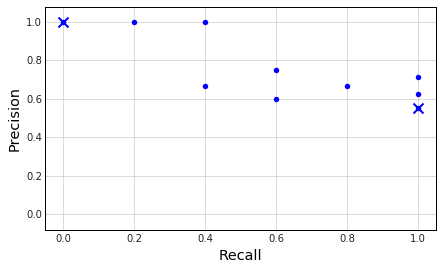

In [4]:
%matplotlib inline
ranked_predictions = [1,1,0,1,0,1,1,0,0,0]
p, r = operating_points(ranked_predictions)
plot_recall_precision(p, r)

Notice that there are always two operating points that are independent of our scores:

+ The first corresponds to a threshold _above_ the highest score: that means we label **all** of the examples as negatives, and so the recall is trivially 0 and we just defined the precision to be 1.

+ The second corresponds to a threshold _below_ the lowest score: that means we predict 1 for all of the examples. In this case, recall is 1, and precision is the underlying rate of positives in the dataset.

If a model assigns the same score to all of the examples, then these are the **only** operating points we see (because the labels are all the same for all thresholds):

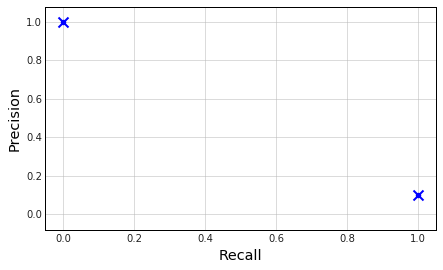

In [5]:
obs, constant_preds = generate_data_and_constant_predictions(
    n=100, frac_positive=0.1)

plot_recall_precision_from_predictions(obs, constant_preds)

Good classifiers will have both high precision and high recall, so we want to see operating points near the top-right of the grid. It's natural, then, to interpret our goal as to maximize the area under a precision&ndash;recall curve defined by all of the operating points: the **interpolated average precision** (IAP). 

Since the curve currently consists of a series of points, we need to fill in the spaces. It's tempting to join the points together with a straight line. Let's try it with our previous example, in which we predicted the same score for all the examples:

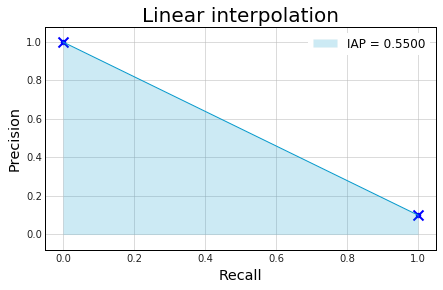

In [6]:
plot_recall_precision_from_predictions(
    obs, constant_preds, 
    interpolation='linear',
    title='Linear interpolation')

This suggests that there's a way to get a precision &approx; 0.8 with a recall of 0.2. But consider how we usually think about interpolation: it's a process that assumes we simply haven't made enough observations to fill the gaps, and so we predict where a point would appear if we observed something at that x-value. Interpolation should reflect what a scatter plot would look like in the limit of infinite data. But this isn't the case here: no matter how much data we have, we'll still only have two possible precision values: 1.0 and 0.1.

So if we can't just draw a straight line, what should the graph look like such that we can compute a meaningful area?

## Proposal: step-wise interpolation

Let's think about the precision we can _actually_ achieve if we demand a recall of 0.2. We can't choose a threshold that gives a recall of exactly 0.2, so we should instead ask _"What precision can I achieve if I recall **at least** 20% of the true positives?"_ With this do-nothing classifier the answer now is easy: 0.1, which we achieve when we assign **every** point to <em>B&plus;</em>. This reflects the definition used in, for example, Manning et al's [Information Retrieval](http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html).

What would this look like?

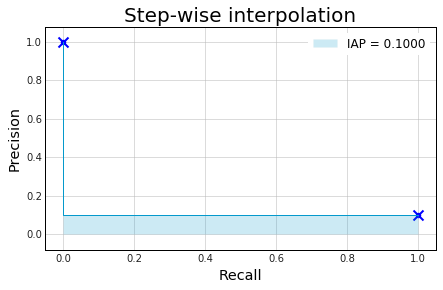

In [7]:
plot_recall_precision_from_predictions(
    obs, constant_preds, 
    interpolation='step',
    title='Step-wise interpolation')

For every value of recall greater than 0, the precision is exactly 0.1. Rather than interpolating linearly between adjacent operating points, we instead use a step function consisting of horizontal and vertical lines. Notice that it no longer matters how we define the precision when recall is exactly 0 since there is no area under that point.

## The intuition behind step-wise interpolation

This may seem a little arbitrary, but I hope I can convince you that this is the natural way to interpolate these points.

Imagine that, instead of assigning a score of 0.5 to each of the examples, our classifier is actually producing a long floating point number, but we only see that number after it has been rounded to some arbitrary precision. So perhaps the scores are [0.500001, 0.499992, &hellip;]. Since we can't recover the actual scores, we can hallucinate them by adding some tiny amount of noise to the scores. This is equivalent to insisting that the classifier produce a strict ranking by arbitrarily breaking ties.

Now if we plot the operating points without any interpolation, we see that we approximate the shape in the previous figure:

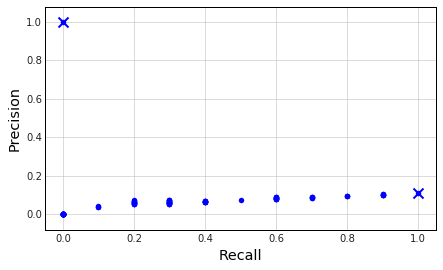

In [8]:
some_noise = np.random.normal(
    loc=0, scale=0.1, size=len(constant_preds))

noisy_preds = constant_preds + some_noise

plot_recall_precision_from_predictions(
    obs, noisy_preds)

If we continue adding observations where the positive and negative data are in the same ratio, the operating points get closer and closer to the horizontal line above:

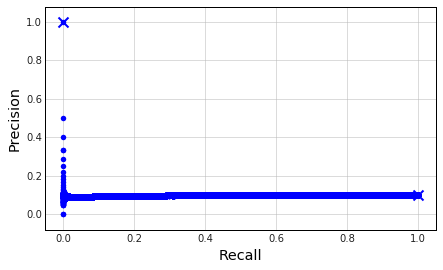

In [9]:
many_obs, many_constant_preds = generate_data_and_constant_predictions(
    n=100000, frac_positive=0.1)

much_noise = np.random.normal(
    loc=0, scale=0.1, size=len(many_constant_preds))

noisy_preds = many_constant_preds + much_noise

plot_recall_precision_from_predictions(many_obs, noisy_preds)

## Scikit-learn

Unfortunately, [sklearn.metrics.average_precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) linearly interpolates between points. This systematically over-estimates the AP score when there are more negatives than positives in the data. 

Since we would only use IAP to compare models, we might think this doesn't matter. But consider two models: one which produces our do-nothing output above (0.5 for all examples), and another that correctly classifies a single positive example at the expense of misclassifying a single negative example. The remaining examples continue to have a score of 0.5:

In [10]:
better_preds = copy(constant_preds)
better_preds[0] = 0.8
better_preds[-1] = 0.8

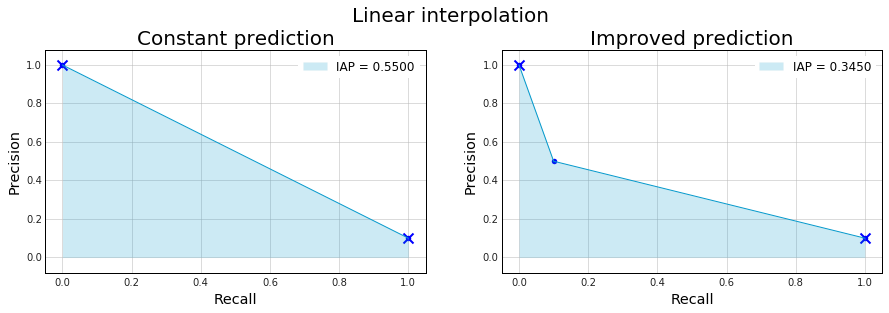

In [11]:
compare_recall_precisions_from_predictions(
    obs, 
    OrderedDict([['Constant prediction', constant_preds], 
                 ['Improved prediction', better_preds]]), 
    interpolation='linear',
    title='Linear interpolation')

If we trusted this measure, we'd conclude that the do-nothing model was better than a model that can achieve a true positive rate of 10% at the expense of a false positive rate of only 0.1%. With uneven datasets like the one we're working on here (10% positives), it's incredibly difficult to add an operating point _above_ the line joining the end points. 

We can instead use the step interpolation strategy, which comes from comparing these graphs:

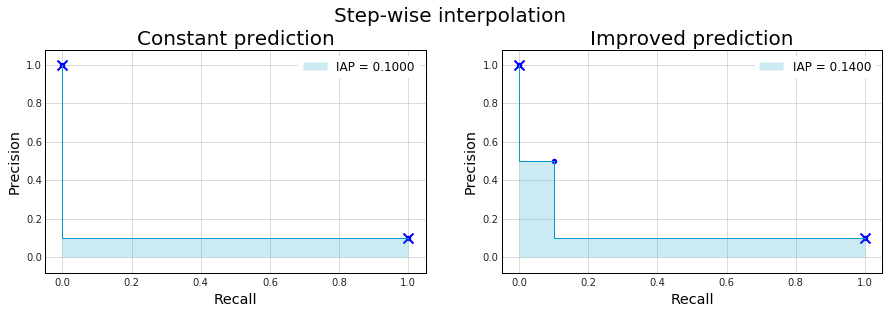

In [12]:
compare_recall_precisions_from_predictions(
    obs, 
    OrderedDict([['Constant prediction', constant_preds], 
                 ['Improved prediction', better_preds]]), 
    interpolation='step',
    title='Step-wise interpolation')

Now the second model is preferred to the first. (We should note that the area is still very low: given the unevenness of the classes, this is inevitable without a very good model or a very easy task!)

## Hammering home the point

In case you need further convincing, let's train a model that classifies a heavily-unbalanced dataset (only 5% of examples have a positive label). This model achieves an ROC AUC score of around 0.6 &mdash; good but not spectacular:

In [13]:
y, scores, roc_auc = train_model_and_evaluate(
    n_dim=50, n_samples=5000, frac_positive=0.05, mixing_factor=0.02)

print("Model achieves ROC AUC of {:4.4f}".format(roc_auc))

Model achieves ROC AUC of 0.5918


Now let's invent a second model which simply **rounds** the first model's scores to the nearest tenth. So a score of 0.5321 is mapped to 0.5. We can use linear interpolation to compare the interpolated average precision for the two models:

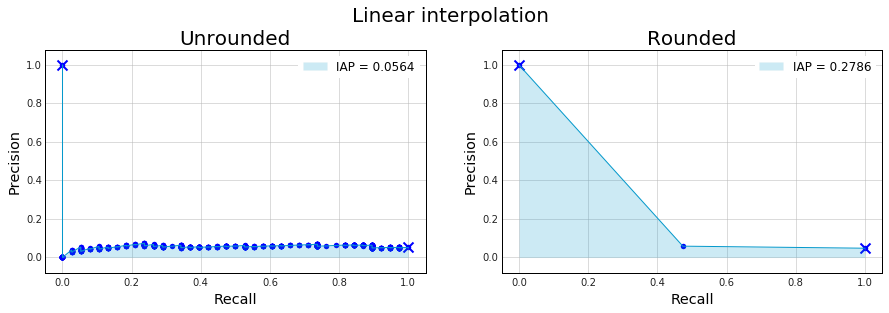

In [14]:
compare_recall_precisions_from_predictions(
    y, OrderedDict([['Unrounded', scores], 
                    ['Rounded',   np.round(scores, 1)]]), 
    interpolation='linear',
    title='Linear interpolation')

According to this metric, we should prefer the second model. It's hard to imagine a scenario where throwing away detail should improve a reasonably-good model, and so we should be skeptical about the efficacy of linear interpolation. 

Let's repeat the comparison, but this time using step interpolation:

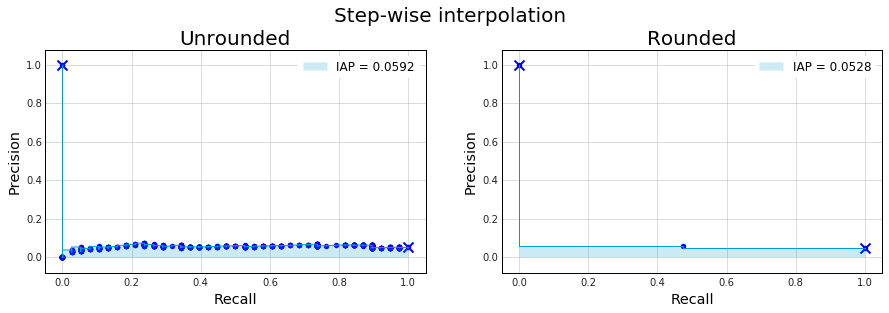

In [15]:
compare_recall_precisions_from_predictions(
    y, OrderedDict([['Unrounded', scores], 
                    ['Rounded',   np.round(scores, 1)]]), 
    interpolation='step',
    title='Step-wise interpolation')

This time the comparison shows what we expect: the unrounded model is better.

## Code

We have submitted a PR to scikit-learn adding step interpolation as an option in the [`sklearn.metrics.average_precision`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score). Hopefully this will be incorporated into the main branch soon, but in the mean time, feel free to use our implementation.